# Expression analysis

Following Fig 7 in the manuscript.

The raw expression data can be found [here](https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-BRCA.htseq_fpkm.tsv.gz). Please place this file at `../data/expression/TCGA-BRCA.htseq_fpkm.tsv` to enable this notebook to run.

The probe map is available [here](https://github.com/ucscXena/xena-GDC-ETL/blob/master/xena_gdc_etl/resources/gencode.v22.annotation.gene.probeMap). Please place this file at `../data/expression/gencode.v22.annotation.gene.probeMap` to enable this notebook to run.

In [1]:
# 0 - imports
import matplotlib.pyplot as plt
import palettable as pal
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

from analysis.utils import load_pre_post_processing, robust_z_score
import analysis.cluster as clu
import analysis.visualizations as vis
from analysis.cox import CoxModel

%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'

palette = pal.cartocolors.qualitative.Safe_8.mpl_colors
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing(prefix="../")

In [3]:
brca_meta_names = list(meta_data["brca"].columns)
prad_meta_names = list(meta_data["prad"].columns)
luad_meta_names = list(meta_data["luad"].columns)

common_meta = set(brca_meta_names).intersection(prad_meta_names).intersection(luad_meta_names)

### Metadata preprocessing

Jusy copying it all.

In [4]:
brca_fib_nuhifs = fibroblast_nuhif_data["brca"].copy()
brca_meta = meta_data["brca"].copy()

### RNAseq Preprocessing

In [5]:
# raw lfpkm = log2(fpkm + 1)
# https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-BRCA.htseq_fpkm.tsv.gz
lfpkm = pd.read_csv("../data/expression/TCGA-BRCA.htseq_fpkm.tsv", delimiter="\t", index_col=0)

# convert to tpm
fpkm = 2**lfpkm - 1
def fpkm_to_tpm(data):
    return data/np.sum(data)
tpm = fpkm.apply(fpkm_to_tpm) * 1_000_000

# change to indexed on slide
slide_to_case = dict(brca_meta['bcr_patient_barcode'])
case_to_slide = {value:key for key,value in slide_to_case.items()}
barcode_to_slide = {}
for rnaseq_barcode in list(tpm.columns):
    is_tumor = rnaseq_barcode[-3:] == "01A"
    has_slide = rnaseq_barcode[:-4] in list(case_to_slide.keys())
    if is_tumor and has_slide:
        barcode_to_slide[rnaseq_barcode] = case_to_slide[rnaseq_barcode[:-4]]
tpm = tpm[list(barcode_to_slide.keys())]
tpm = tpm.rename(columns=barcode_to_slide).transpose()

In [6]:
# load in the gene names
probe_map = pd.read_csv("../data/expression/gencode.v22.annotation.gene.probeMap", delimiter="\t", index_col=0)
gene_names = []
for gene in probe_map["gene"].values:
    new_gene = gene.split(".")[0]#.split("-")[0]
    gene_names.append(new_gene)
probe_map["gene_name"] = gene_names

# drop gene names that occur multiple times, make dict for remapping
gene_counter = Counter(probe_map["gene_name"].values)
unmapped_ids = []
multiply_mapped_genes = []
tpm_remapped = {}
for eid in list(probe_map.index):
    gene_name = probe_map.loc[eid]["gene_name"]
    
    # if its a 1-1 mapping just add it with the new name
    # if its >1-1 mapping, add them and map it

    # check if already added
    if gene_name not in list(tpm_remapped.keys()): 
        # drop it in
        tpm_remapped[gene_name] = tpm[eid].values
    else:
        tpm_remapped[gene_name] = tpm_remapped[gene_name] + tpm[eid].values
    
    # otherwise ignore it
    if gene_counter[gene_name]==0:
        unmapped_ids.append(eid)

tpm_remapped = pd.DataFrame(tpm_remapped)
tpm_remapped["H & E_ID"] = tpm.index.values
tpm_remapped.set_index("H & E_ID", inplace=True)

print(f"{len(unmapped_ids)} probes are missing and discarded.")

0 probes are missing and discarded.


In [7]:
tpm = tpm_remapped.copy()
tpm.head()

,DDX11L1,WASH7P,MIR6859-3,RP11-34P13,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,CICP27,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
H & E_ID,,,,,,,,,,,,,,,,,,,,,
87439,0.032012,21.890793,0.000000,8.352114,0.0,0.0,0.0,0.0,0.0,0.014570,...,12179.296767,0.00000,0.941381,0.000000,1340.688449,1751.724428,0.00000,6294.389342,1.683074,1230.896540
83579,0.000000,19.957568,0.000000,14.355273,0.0,0.0,0.0,0.0,0.0,0.041988,...,28741.627818,0.00000,0.000000,0.563583,5474.706126,5863.594385,0.00000,15475.574104,7.275344,2207.852814
91225,0.000000,7.637866,3.533373,42.212906,0.0,0.0,0.0,0.0,0.0,0.299391,...,26893.998575,0.00000,0.000000,0.846019,8053.963540,9808.024917,0.00000,17919.757838,2.730334,1757.853184
80413,0.000000,24.930803,0.000000,17.034080,0.0,0.0,0.0,0.0,0.0,0.033320,...,21490.180075,0.00000,0.000000,0.000000,7597.266062,7111.355191,0.00000,14498.701836,13.471454,2731.790146
87815,0.000000,47.216190,5.205318,24.106011,0.0,0.0,0.0,0.0,0.0,0.145914,...,20294.926865,1.46568,0.000000,1.424393,4509.076332,3902.342968,0.73284,8574.629131,8.427658,1481.284909


In [8]:
# match tpm and hifs and meta and nuhifs
common_slides = set(list(tpm.index)).intersection(list(brca_fib_nuhifs.index), list(brca_meta.index))

tpm = tpm.loc[common_slides].copy()
brca_fib_nuhifs = brca_fib_nuhifs.loc[common_slides].copy()
brca_meta = brca_meta.loc[common_slides].copy()

In [9]:
brca_meta.shape

(864, 14)

Text(0, 0.5, 'N')

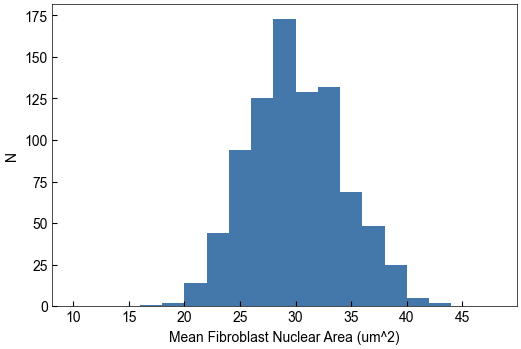

In [10]:
plt.figure()
plt.hist(brca_fib_nuhifs["MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E"], bins=np.arange(10, 50, 2))
plt.xlabel("Mean Fibroblast Nuclear Area (um^2)")
plt.ylabel("N")

#### TPM Normalization

We should now take the log to get the normed TPM

In [11]:
normed_hifs = brca_fib_nuhifs.copy()
normed_tpm = np.log2(tpm + 1).copy()

### Analysis 

First, we should define some analysis functions.

In [12]:
def ols_metric(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return {"OLS a": slope, "OLS b": intercept, "OLS rsq":r_value**2, "OLS p": p_value}

def pearson_metric(x, y):
    pearsonr, pearsonp = stats.pearsonr(x,y)
    return {"Pearson r": pearsonr, "Pearson p": pearsonp}

def spearman_metric(x, y):
    spearmanr, spearmanp = stats.spearmanr(x,y)
    return {"Spearman rho": spearmanr, "Spearman p": spearmanp}

def analysis_for_hif(hif_df, rnaseq_df, rho_thresh=0.25, hif_shorthand=None):
    """
    HIF df and RNAseq df should be normalized identically
    """
    assert(len(hif_df.columns)==1)
    hif_name = hif_df.columns[0]
    if not hif_shorthand:
        hif_shorthand = hif_name

    assert all(hif_df.index == rnaseq_df.index), "HIF df and RNAseq df do not have matching cases."
    rnaseq_names = list(rnaseq_df.columns)
    pearson_rs = {}
    spearman_rs = {}
    olss = {}
    
    # rnaseq analysis
    for gene_name in rnaseq_names:
        x, y = hif_df[hif_name].values, rnaseq_df[gene_name].values
        if len(np.unique(y))==1:
            pass
        else:
            pearson_rs[gene_name] = pearson_metric(x, y)
            spearman_rs[gene_name] = spearman_metric(x, y)
            olss[gene_name] = ols_metric(x, y)

    pearson_df = pd.DataFrame.from_dict(pearson_rs).transpose()
    pearson_df["Pearson adj p"] = multipletests(pearson_df["Pearson p"].values, method="fdr_bh", alpha=0.05)[1]
    spearman_df = pd.DataFrame.from_dict(spearman_rs).transpose()
    spearman_df["Spearman adj p"] = multipletests(spearman_df["Spearman p"].values, method="fdr_bh", alpha=0.05)[1]
    ols_df = pd.DataFrame.from_dict(olss).transpose()
    ols_df["OLS adj p"] = multipletests(ols_df["OLS p"].values, method="fdr_bh", alpha=0.05)[1]

    summary_df = pearson_df.join(spearman_df).join(ols_df)
    summary_df.sort_values("Spearman rho", axis=0, inplace=True, ascending=False)
    summary_df[["Spearman rho", "Spearman p", "Spearman adj p"]].to_csv(f"../data/expression/{hif}_vs_tpm_summary.csv")
    
    gene_set_generation(summary_df, hif_shorthand, adj_p_thresh=0.05, rho_thresh=rho_thresh)
    
    return summary_df

def gene_set_generation(
    summary_df, 
    hif_shorthand, 
    adj_p_thresh=0.05,
    rho_thresh=0.25
):
    """GSEA on positively or negatively correlated genes."""
    summary_significant = summary_df[summary_df["Spearman adj p"] < 0.05].copy()
    summary_up = summary_significant[summary_significant["Spearman rho"] > rho_thresh].copy()
    summary_down = summary_significant[summary_significant["Spearman rho"] < -1*rho_thresh].copy()
    
    gene_list_up = list(summary_up.index[:500])
    gene_list_down = list(summary_down.index[:500])

    df1 = pd.DataFrame({"up": gene_list_up})
    df2 = pd.DataFrame({"down": gene_list_down})
    pd.concat([df1, df2], axis=1).to_csv(f"../data/expression/{hif}_gene_set_table.csv")

In [13]:
# reset features and metadata
selected_hif_names = ["MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E"]
selected_hif_shorthand = ["Mean Fibroblast Nuclear Area (um^2)"]

In [14]:
summaries = {}
for hif, hif_shorthand in zip(selected_hif_names, selected_hif_shorthand):
    print(f"{hif_shorthand}")
    summary_df = analysis_for_hif(normed_hifs[[hif]], normed_tpm, rho_thresh=0.15, hif_shorthand=hif_shorthand)
    
    print("Top genes identified:")
    display(summary_df.iloc[:5])
    display(summary_df.iloc[-5:])
    print("\n\n\n\n")
    summaries[hif] = {"summary_df":summary_df}

Mean Fibroblast Nuclear Area (um^2)
Top genes identified:


,Pearson r,Pearson p,Pearson adj p,Spearman rho,Spearman p,Spearman adj p,OLS a,OLS b,OLS rsq,OLS p,OLS adj p
ARSI,0.270526,5.887027e-16,2.803814e-11,0.254726,2.909468e-14,9.410506e-10,0.065063,0.388748,0.073184,5.887027e-16,2.803814e-11
PTPRN,0.179831,1.027919e-07,1.615732e-05,0.253439,3.951753e-14,9.410506e-10,0.032397,-0.387671,0.032339,1.027919e-07,1.615732e-05
IGFL3,0.260809,6.684675e-15,1.181209e-10,0.244728,3.002324e-13,3.923916e-09,0.074338,-1.119709,0.068021,6.684675e-15,1.181209e-10
TNFRSF12A,0.249077,1.101664e-13,1.049379e-09,0.244320,3.295539e-13,3.923916e-09,0.063197,4.245018,0.062039,1.101664e-13,1.049379e-09
PPAPDC1A,0.237648,1.474080e-12,4.311814e-09,0.241118,6.801044e-13,6.478267e-09,0.081121,1.034031,0.056477,1.474080e-12,4.311814e-09


,Pearson r,Pearson p,Pearson adj p,Spearman rho,Spearman p,Spearman adj p,OLS a,OLS b,OLS rsq,OLS p,OLS adj p
RP11-16E12,-0.194536,8.163449e-09,2.666016e-06,-0.206990,8.145348e-10,9.461914e-07,-0.035885,2.426062,0.037844,8.163449e-09,2.666016e-06
RAB37,-0.227102,1.436351e-11,2.533670e-08,-0.208338,6.290496e-10,7.804833e-07,-0.042216,3.117070,0.051575,1.436351e-11,2.533670e-08
KCNJ10,-0.236800,1.777407e-12,4.455397e-09,-0.216418,1.288859e-10,2.275694e-07,-0.034091,1.679916,0.056074,1.777407e-12,4.455397e-09
AC007386,-0.211659,3.304149e-10,3.085622e-07,-0.224491,2.481144e-11,7.811835e-08,-0.028560,1.688473,0.044799,3.304149e-10,3.085622e-07
PIM2,-0.242772,4.683395e-13,2.720819e-09,-0.230296,7.292535e-12,3.157469e-08,-0.055296,6.585579,0.058938,4.683395e-13,2.720819e-09


Text(0, 0.5, 'ARSI')

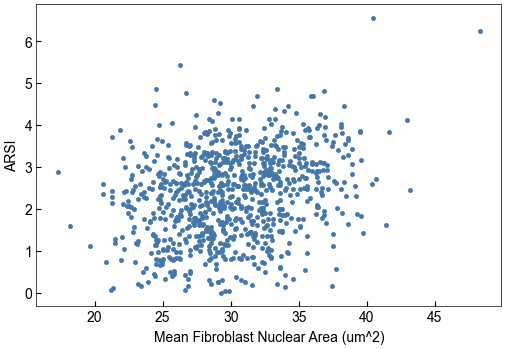

In [15]:
plt.scatter(normed_hifs[selected_hif_names[0]], normed_tpm["ARSI"])
plt.xlabel(selected_hif_shorthand[0])
plt.ylabel("ARSI")